In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir")

options = Option(
    inputModel = 'KERAS_lstm_model_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    jsonModel = 'KERAS_lstm_model.json',
    outputDir = '/output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


In [4]:
# To use one data file:
h5File = h5py.File(options.inputFile, 'r')
treeArray = h5File[options.tree][()]

#print(treeArray.shape)
#print(treeArray.dtype.names)

# List of features to use
features = yamlConfig['Inputs']

# List of labels to use
labels = yamlConfig['Labels']

# Convert to dataframe
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]

labels_df = labels_df.drop_duplicates()

# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values

if 'j_index' in features:
    features_val = features_val[:,:-1] # drop the j_index feature
if 'j_index' in labels:
    labels_val = labels_val[:,:-1] # drop the j_index label
    print(labels_val.shape)

(24816, 5)


In [5]:
features_2dval = np.zeros((len(labels_df), yamlConfig['MaxParticles'], len(features)-1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values
    #features_val_i = features_val[index_values[0]:index_values[-1]+1,:-1] # drop the last feature j_index
    features_val_i = features_val[np.array(index_values),:]
    nParticles = len(features_val_i)
    #print("before", features_val_i[:,0])
    features_val_i = features_val_i[features_val_i[:,0].argsort()[::-1]] # sort descending by first value (ptrel, usually)
    #print("after", features_val_i[:,0])
    if nParticles>yamlConfig['MaxParticles']:
        features_val_i =  features_val_i[0:yamlConfig['MaxParticles'],:]
    else:        
        features_val_i = np.concatenate([features_val_i, np.zeros((yamlConfig['MaxParticles']-nParticles, len(features)-1))])
    features_2dval[i, :, :] = features_val_i
    
features_val = features_2dval

X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [6]:
reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0]*X_train_val.shape[1],X_train_val.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train_val.shape[1]):
    X_train_val[:,p,:] = scaler.transform(X_train_val[:,p,:])
    X_test[:,p,:] = scaler.transform(X_test[:,p,:])    
if 'j_index' in labels:
    labels = labels[:-1]

In [7]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

In [8]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                    validation_split = 0.25, shuffle = True, callbacks = None, 
                    use_multiprocessing=True, workers=4)

Epoch 1/100
15/15 [==============================] - 1s 59ms/step - loss: 0.7167 - accuracy: 0.8849 - val_loss: 0.4741 - val_accuracy: 0.9220
Epoch 2/100
15/15 [==============================] - 1s 43ms/step - loss: 0.3740 - accuracy: 0.9346 - val_loss: 0.3186 - val_accuracy: 0.9404
Epoch 3/100
15/15 [==============================] - 1s 43ms/step - loss: 0.2726 - accuracy: 0.9421 - val_loss: 0.2502 - val_accuracy: 0.9379
Epoch 4/100
15/15 [==============================] - 1s 43ms/step - loss: 0.2268 - accuracy: 0.9356 - val_loss: 0.2163 - val_accuracy: 0.9337
Epoch 5/100
15/15 [==============================] - 1s 44ms/step - loss: 0.1984 - accuracy: 0.9374 - val_loss: 0.1943 - val_accuracy: 0.9389
Epoch 6/100
15/15 [==============================] - 1s 44ms/step - loss: 0.1801 - accuracy: 0.9433 - val_loss: 0.1794 - val_accuracy: 0.9438
Epoch 7/100
15/15 [==============================] - 1s 44ms/step - loss: 0.1661 - accuracy: 0.9479 - val_loss: 0.1687 - val_accuracy: 0.9470
Epoch 

15/15 [==============================] - 1s 45ms/step - loss: 0.0647 - accuracy: 0.9915 - val_loss: 0.0742 - val_accuracy: 0.9875
Epoch 59/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0642 - accuracy: 0.9919 - val_loss: 0.0737 - val_accuracy: 0.9875
Epoch 60/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0639 - accuracy: 0.9915 - val_loss: 0.0736 - val_accuracy: 0.9881
Epoch 61/100
15/15 [==============================] - 1s 58ms/step - loss: 0.0636 - accuracy: 0.9923 - val_loss: 0.0729 - val_accuracy: 0.9875
Epoch 62/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0632 - accuracy: 0.9918 - val_loss: 0.0728 - val_accuracy: 0.9883
Epoch 63/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0627 - accuracy: 0.9925 - val_loss: 0.0723 - val_accuracy: 0.9881
Epoch 64/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0625 - accuracy: 0.9923 - val_loss: 0.0717 - val_accuracy: 0.9889
Epoch 65/100

In [9]:
model.save('LSTM') #Saves to local directory;

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: LSTM\assets


In [10]:
loaded_model = keras.models.load_model('LSTM') #Loads from local directory

In [11]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


In [12]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

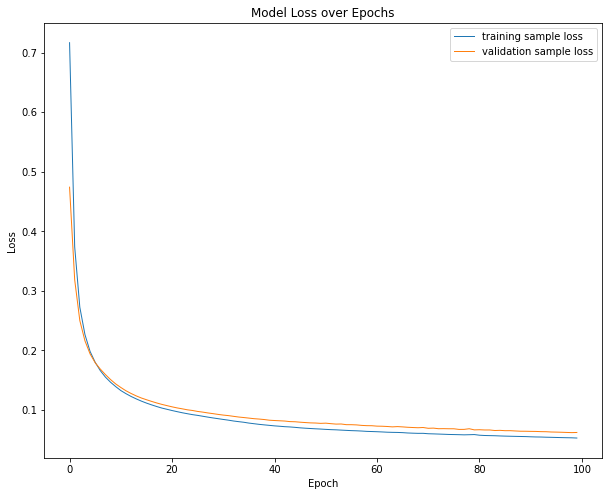

In [13]:
learningCurve(history)

In [14]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

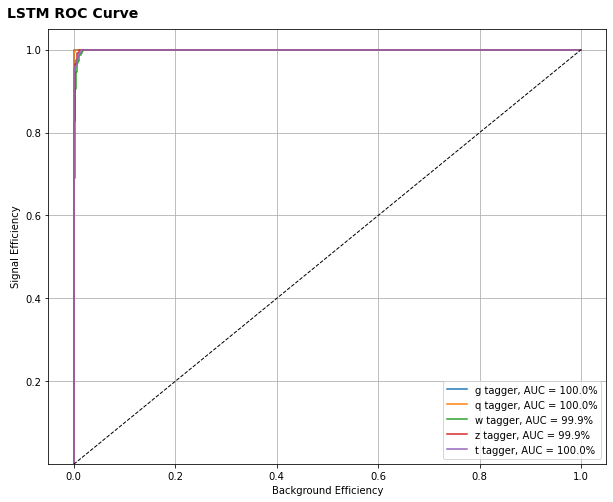

In [15]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='LSTM')